# Feature Extraction Using SIFT and Feature Matching Using FLANN

Best match: M2-026-01-sz1.jpg (Score: 97)


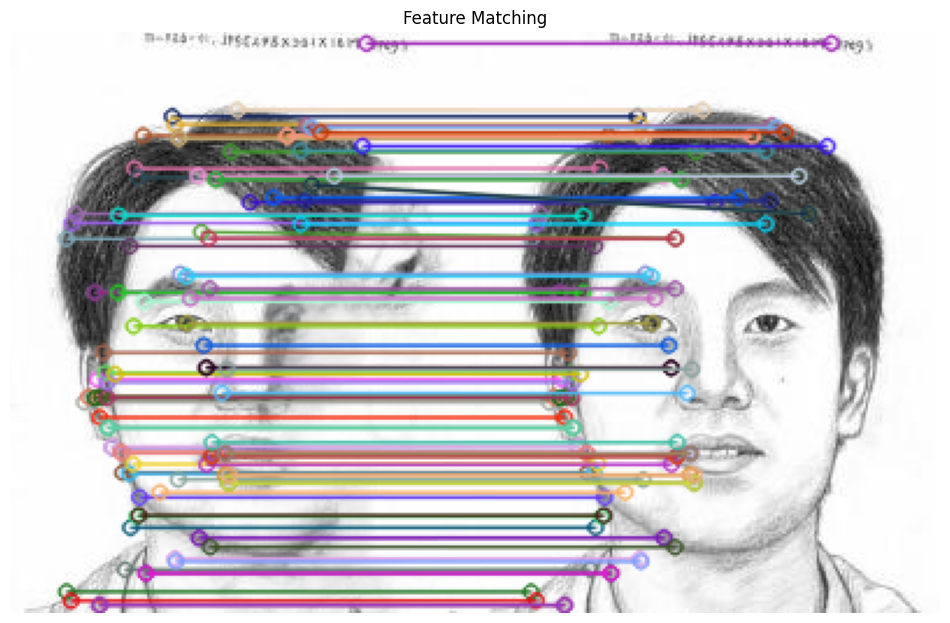

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

original_dir = "archive/sketches"
distorted_image_path = "archive/Distorted/16.jpg"  

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Function to find the best match
def find_best_match(distorted_image_path, original_dir):
    distorted_image = cv2.imread(distorted_image_path, cv2.IMREAD_GRAYSCALE)
    kp1, des1 = sift.detectAndCompute(distorted_image, None)

    best_match_file = None
    best_score = float('-inf')
    best_matches = []
    best_match_image = None

    # FLANN parameters
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    for filename in os.listdir(original_dir):
        original_path = os.path.join(original_dir, filename)
        original_image = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
        if original_image is None:
            continue

        kp2, des2 = sift.detectAndCompute(original_image, None)
        if des2 is None:
            continue

        matches = flann.knnMatch(des1, des2, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

        if len(good_matches) > 10:
            src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            _, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            score = np.sum(mask)

            if score > best_score:
                best_score = score
                best_match_file = filename
                best_matches = good_matches
                best_match_image = original_image

    return best_match_file, best_score, best_matches, distorted_image, best_match_image

# Find the best match
best_match_file, best_score, best_matches, distorted_image, best_match_image = find_best_match(distorted_image_path, original_dir)

if best_match_file:
    print(f"Best match: {best_match_file} (Score: {best_score})")
    # Visualize matches
    kp1 = sift.detectAndCompute(distorted_image, None)[0]
    kp2 = sift.detectAndCompute(best_match_image, None)[0]
    matched_image = cv2.drawMatches(
        cv2.imread(distorted_image_path), kp1,
        cv2.imread(os.path.join(original_dir, best_match_file)), kp2,
        best_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title("Feature Matching")
    plt.axis("off")
    plt.show()
else:
    print("No suitable match found.")


# Restoring Image Using CLAHE

In [ ]:
def restore_image_with_reference(input_path, reference_path, output_path):
    distorted = cv2.imread(input_path)
    reference = cv2.imread(reference_path)

    if distorted is None or reference is None:
        print("Error: Unable to load the images.")
        return

    reference_resized = cv2.resize(reference, (distorted.shape[1], distorted.shape[0]))
    distorted_lab = cv2.cvtColor(distorted, cv2.COLOR_BGR2LAB)
    reference_lab = cv2.cvtColor(reference_resized, cv2.COLOR_BGR2LAB)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_distorted, a_distorted, b_distorted = cv2.split(distorted_lab)
    l_reference, _, _ = cv2.split(reference_lab)

    l_corrected = clahe.apply(l_distorted)
    l_blended = cv2.addWeighted(l_corrected, 0.5, l_reference, 0.5, 0)

    restored_lab = cv2.merge((l_blended, a_distorted, b_distorted))
    restored_bgr = cv2.cvtColor(restored_lab, cv2.COLOR_LAB2BGR)

    cv2.imwrite(output_path, restored_bgr)
    cv2.imshow("Distorted", distorted)
    cv2.imshow("Reference", reference_resized)
    cv2.imshow("Restored", restored_bgr)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Restore using the best match
if best_match_file:
    restore_image_with_reference(
        input_path=distorted_image_path,
        reference_path=os.path.join(original_dir, best_match_file),
        output_path="archive/Fixed_image.jpg"
    )


# Matching Fixed Sketches With Original Photos Using SSIM

Error processing file .ipynb_checkpoints: Image at path archive/photos\.ipynb_checkpoints could not be loaded.
The best matching photo is: m-077-01.jpg with a similarity score of 0.53


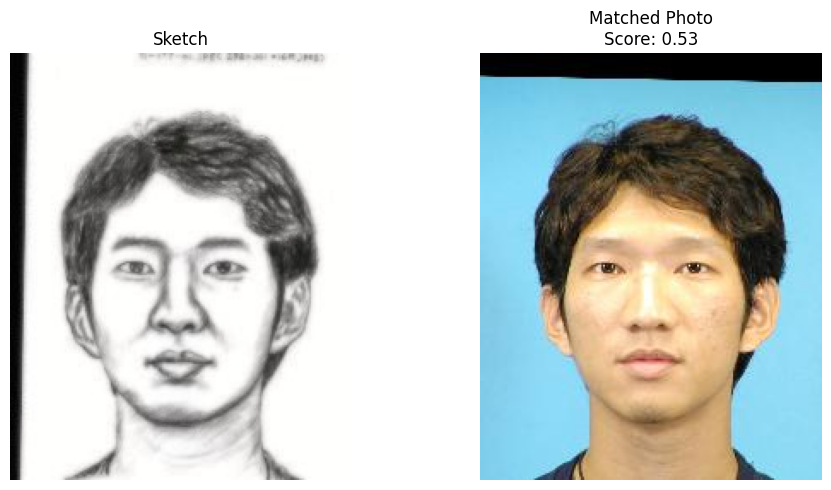

In [3]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

photo_dir = os.path.join('archive/photos')  
sketch_path = os.path.join('archive/Fixed_image.jpg')
img_size = (128, 128)

def preprocess_image(image_path, img_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} could not be loaded.")
    image = cv2.resize(image, img_size)  # Resize the image
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

def find_best_match(sketch_path, photo_dir, img_size):
    sketch = preprocess_image(sketch_path, img_size)  
    best_match = None
    best_score = -1  
    best_match_file = None

    for filename in os.listdir(photo_dir):  
        photo_path = os.path.join(photo_dir, filename)
        try:
            photo = preprocess_image(photo_path, img_size)  

            # Calculate the Structural Similarity Index (SSIM)
            score = ssim(sketch, photo, data_range=photo.max() - photo.min())

            if score > best_score:
                best_score = score
                best_match = photo
                best_match_file = filename
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

    return best_match_file, best_score

# Verify file paths
if not os.path.exists(photo_dir):
    raise FileNotFoundError(f"Photo directory '{photo_dir}' not found.")
if not os.path.exists(sketch_path):
    raise FileNotFoundError(f"Sketch file '{sketch_path}' not found.")

# Find the best match and its similarity score
best_match_file, best_score = find_best_match(sketch_path, photo_dir, img_size)

# Print the result
if best_match_file:
    print(f"The best matching photo is: {best_match_file} with a similarity score of {best_score:.2f}")
    
    
    best_match_display = cv2.imread(os.path.join(photo_dir, best_match_file))
    sketch_display = cv2.imread(sketch_path)

    best_match_display = cv2.cvtColor(best_match_display, cv2.COLOR_BGR2RGB)
    sketch_display = cv2.cvtColor(sketch_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(sketch_display)
    plt.title("Sketch")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(best_match_display)
    plt.title(f"Matched Photo\nScore: {best_score:.2f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No matching photo found.")


# Visualization

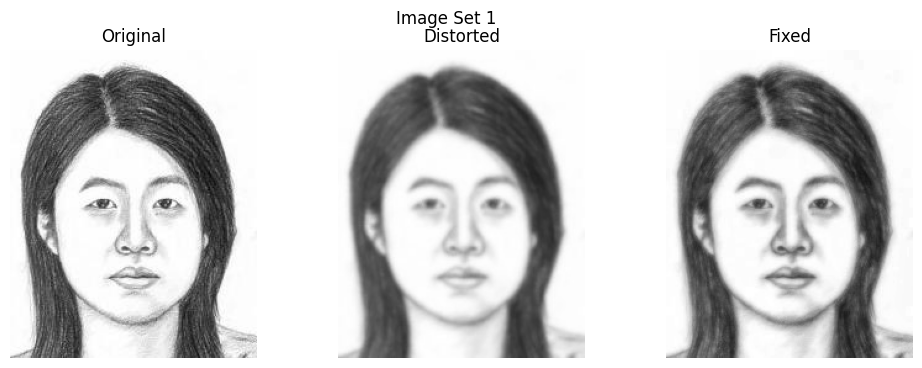

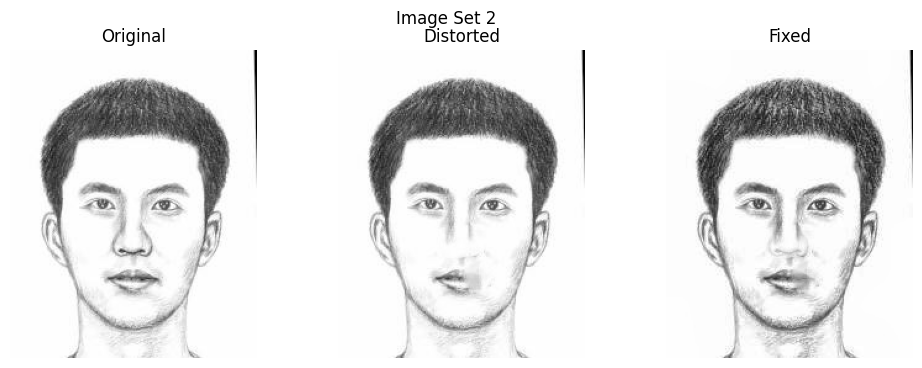

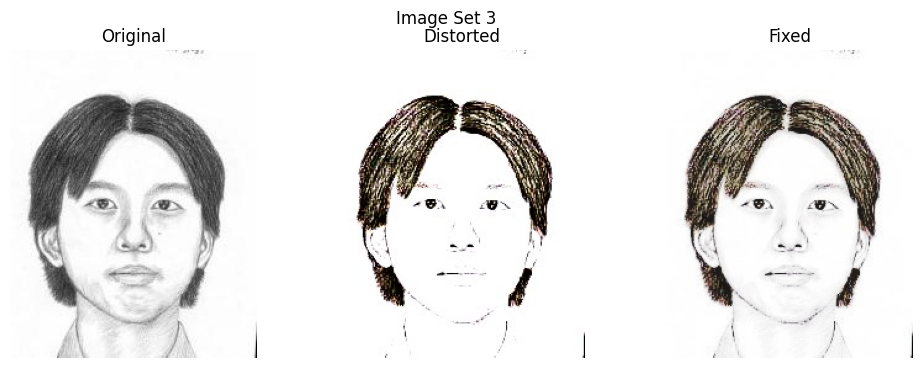

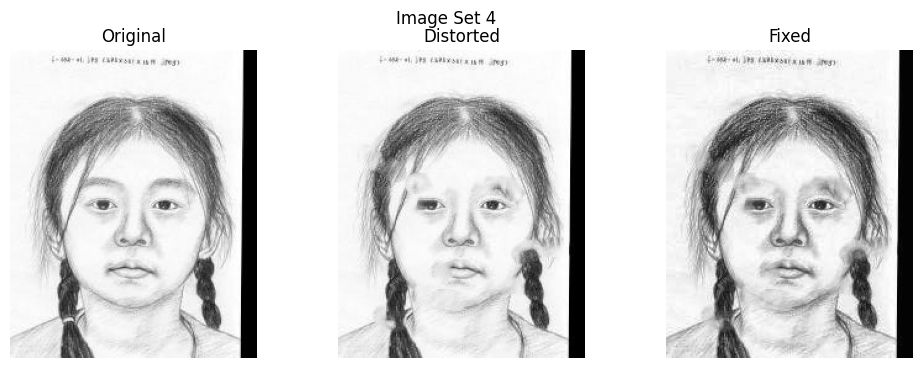

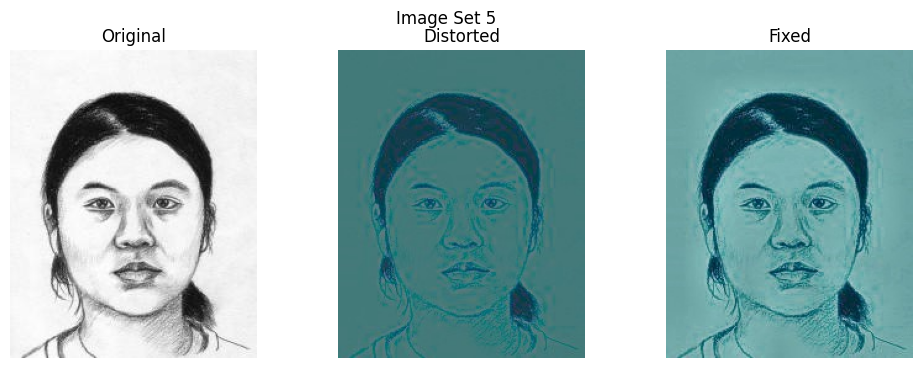

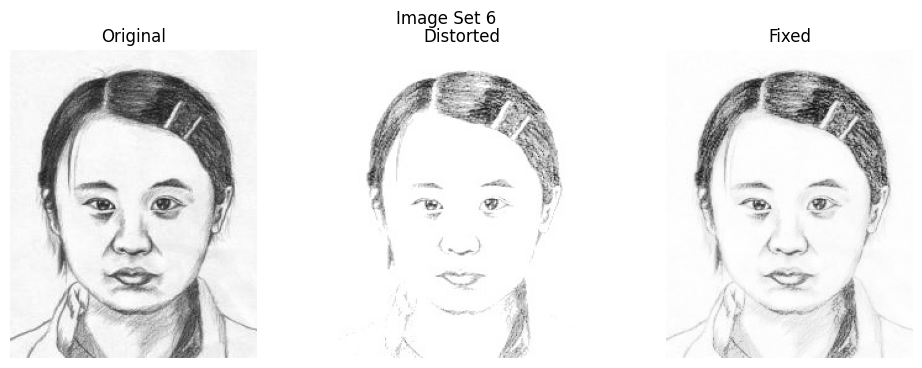

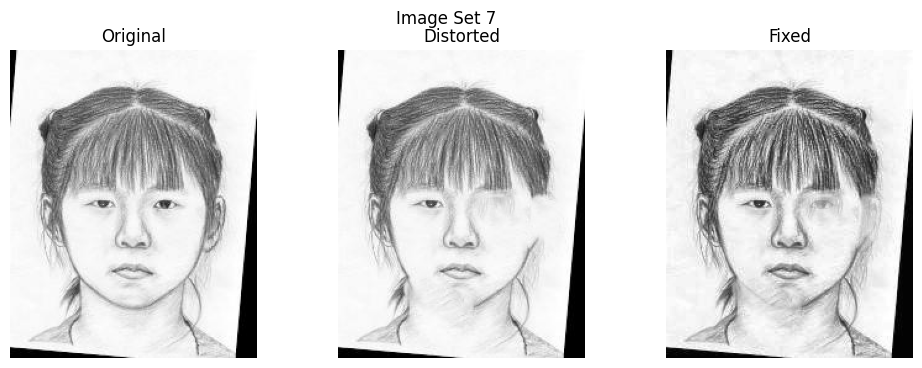

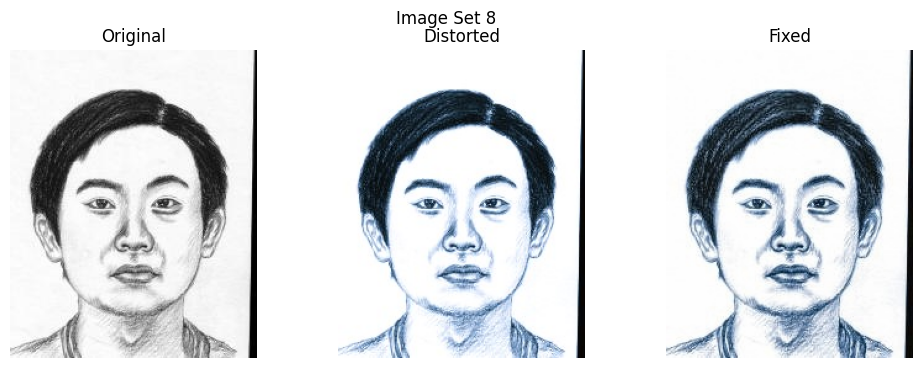

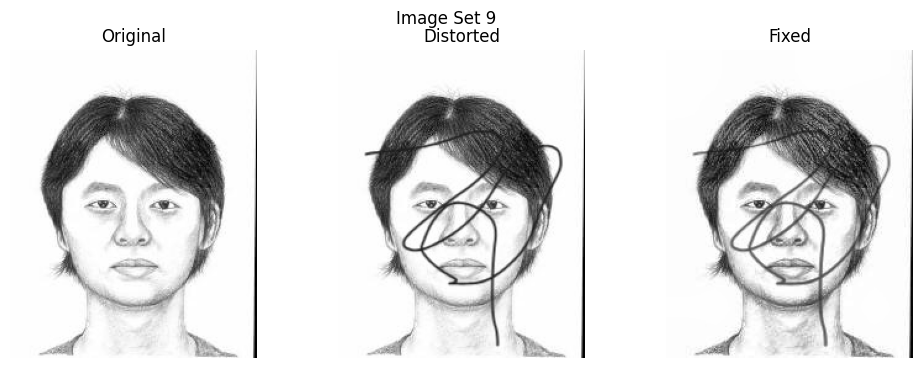

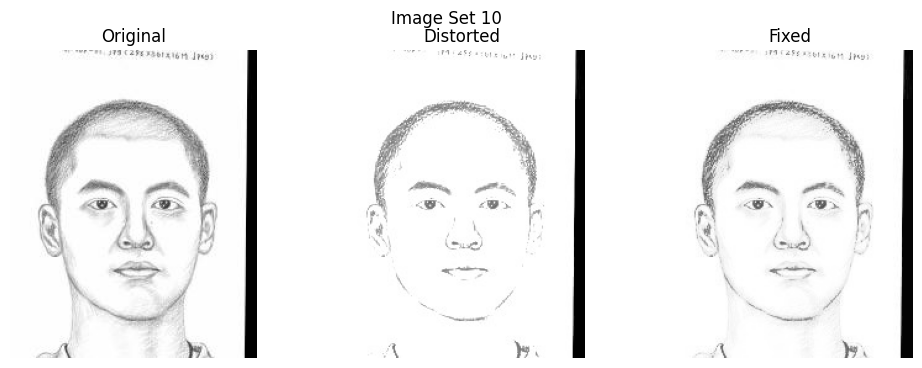

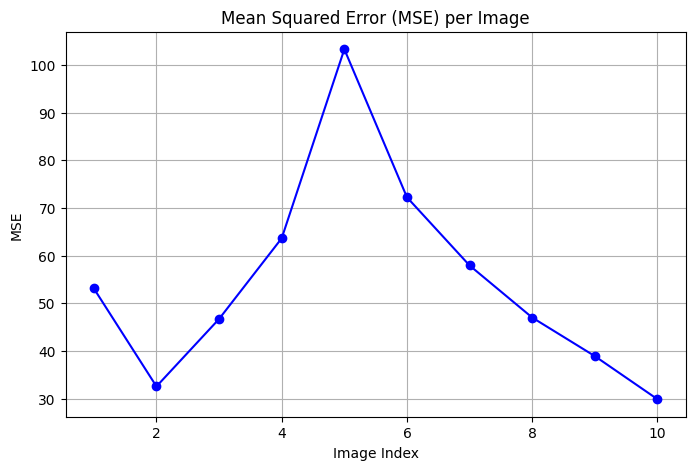

In [81]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_images(original_dir, distorted_dir, fixed_dir):
    original_images = sorted(os.listdir(original_dir))
    distorted_images = sorted(os.listdir(distorted_dir))
    fixed_images = sorted(os.listdir(fixed_dir))

    num_images = min(len(original_images), len(distorted_images), len(fixed_images))

    mse_values = []  # List to store Mean Squared Error values

    for i in range(num_images):
        original_path = os.path.join(original_dir, original_images[i])
        distorted_path = os.path.join(distorted_dir, distorted_images[i])
        fixed_path = os.path.join(fixed_dir, fixed_images[i])

        # Read images using OpenCV
        original_img = cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB)
        distorted_img = cv2.cvtColor(cv2.imread(distorted_path), cv2.COLOR_BGR2RGB)
        fixed_img = cv2.cvtColor(cv2.imread(fixed_path), cv2.COLOR_BGR2RGB)

        # Calculate Mean Squared Error for fixed images
        mse = np.mean((original_img - fixed_img) ** 2)
        mse_values.append(mse)

        # Plot the images
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(distorted_img)
        plt.title("Distorted")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(fixed_img)
        plt.title("Fixed")
        plt.axis("off")

        plt.suptitle(f"Image Set {i + 1}")
        plt.show()

    # Plot the error graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_images + 1), mse_values, marker='o', linestyle='-', color='b')
    plt.title("Mean Squared Error (MSE) per Image")
    plt.xlabel("Image Index")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.show()


# Replace these with the actual paths to your directories
original_dir = "archive/Analysis/OriginalSketches"
distorted_dir = "archive/Analysis/DistortedSketches"
fixed_dir = "archive/Analysis/FixedSketches"

display_images(original_dir, distorted_dir, fixed_dir)